# <a href="https://thetahat.ru/courses/ad" target="_top">Введение в анализ данных</a>

## Статистика в машинном обучении

Этот ноутбук посвящен важности проверки условий применимости моделей и показывает, как различные особенности данных в обучающей выборке могут влиять на итоговый результат обучения.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.graph_objects as go
import random

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

from typing import List, Optional, Tuple, Callable, Dict, Any
sns.set(style="darkgrid", palette="Set2", font_scale=1.3)

In [ ]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### 1. Сходимость коэффициентов линейной регрессии

При работе с моделями, включая линейную регрессию, следует проверять, соответствуют ли данные условиям применимости моделей. Для линейной регрессии важно, чтобы признаки были некоррелированны, так как в противном случае у коэффициентов линейной регрессии может ухудшиться сходимость, а у предсказаний — увеличиться дисперсия.

Это делает модель менее надёжной и предсказуемой, что критично, особенно если её выводы используются для принятия решений в бизнесе или науке.


Давайте проверим это эмпирически: проведём серию запусков модели и проанализируем поведение метрик — в частности, оценим стабильность коэффициентов и дисперсию предсказаний при высокой корреляции признаков.

Вспомогательный код для визуализации. В нем мы обучаем линейную регрессию `n_runs` раз, для каждого размера выборки из `sample_sizes`, сохраняем коэффициенты и визуализируем зависимость коэффициенты от размера выборки.

In [ ]:
def compute_convergence_data_with_generator(
    data_generator: Callable[[int], Tuple[np.ndarray, np.ndarray]],
    sample_sizes: np.ndarray,
    n_runs: int,
    n_coefs: int
) -> Tuple[List[List[float]], List[List[List[float]]]]:
    """
    Вычисляет сходимость свободного коэффициента и коэффициентов линейной регрессии при разных размерах выборки и повторных прогонах.
    Данные заново генерируются на каждом шаге.

    Параметры:
        data_generator: функция, принимающая n и возвращающая (X, y)
        sample_sizes: массив размеров выборки
        n_runs: число запусков
        n_coefs: число признаков

    Возвращает:
        intercepts: список интерсептов [n_runs][n_sample_sizes]
        coefs: список коэффициентов [n_features][n_runs][n_sample_sizes]
    """
    all_intercepts = []
    all_coefs = [[] for _ in range(n_coefs)]

    for run in range(n_runs):
        intercepts = []
        coefs = [[] for _ in range(n_coefs)]

        for size in sample_sizes:
            X, y = data_generator(size)
            model = LinearRegression().fit(X, y)

            intercepts.append(model.intercept_)
            for i in range(n_coefs):
                coefs[i].append(model.coef_[i])

        all_intercepts.append(intercepts)
        for i in range(n_coefs):
            all_coefs[i].append(coefs[i])

    return all_intercepts, all_coefs



def plot_coefficient_convergence(
    data_generator: Callable[[int], Tuple[np.ndarray, np.ndarray]],
    true_intercept: float,
    true_coefs: List[float],
    title: str,
    n_runs: int = 10,
    alpha: float = 0.5,
    size: int = 1000,
    step: int = 20,
    ylims: Optional[List[Tuple[float, float]]] = None
) -> None:
    """
    Строит графики сходимости оценки коэффициентов линейной регрессии
    к их истинным значениям при увеличении размера выборки.

    Параметры:
        data_generator: Функция, генерирующая (X, y) по заданному размеру выборки
        true_intercept: Истинное значение свободного члена
        true_coefs: Список истинных коэффициентов при признаках
        title: Заголовок графика
        n_runs: Кол-во повторов для усреднения (по умолчанию 10)
        alpha: Прозрачность линий (по умолчанию 0.5)
        size: Размер выборки
        step: Шаг размера выборки
        ylims: Ограничения по оси Y для каждого графика [(intercept), (coef1), ...]
    """
    sample_sizes = np.arange(step, size + step, step)
    n_coefs = len(true_coefs)

    # Получаем сходимость оценок свободного члена и коэффициентов
    intercepts, coefs = compute_convergence_data_with_generator(
        data_generator=data_generator,
        sample_sizes=sample_sizes,
        n_runs=n_runs,
        n_coefs=n_coefs
    )

    fig, axs = plt.subplots(1, n_coefs + 1, figsize=(6 * (n_coefs + 1), 5))
    fig.suptitle(title, fontsize=18)

    # График для свободного коэффициента
    axs[0].set_title("Свободный коэффициент")
    axs[0].set_xlabel("Размер выборки")
    axs[0].set_ylabel("Значение")
    axs[0].axhline(true_intercept, color='red', linestyle='--', label="Истинное значение")
    if ylims:
        axs[0].set_ylim(*ylims[0])  # Ограничения по Y, если заданы
    for run in intercepts:
        axs[0].plot(sample_sizes, run, alpha=alpha, color='blue')
    axs[0].legend()

    # Графики для каждого коэффициента
    for i in range(n_coefs):
        axs[i + 1].set_title(f"Коэффициент при x{i + 1}")
        axs[i + 1].set_xlabel("Размер выборки")
        axs[i + 1].set_ylabel("Значение")
        axs[i + 1].axhline(true_coefs[i], color='red', linestyle='--', label="Истинное значение")
        if ylims:
            axs[i + 1].set_ylim(*ylims[i + 1])
        for run in coefs[i]:
            axs[i + 1].plot(sample_sizes, run, alpha=alpha, color='blue')
        axs[i + 1].legend()

    fig.set_constrained_layout(True)
    fig.suptitle(title, fontsize=18)
    plt.show()

Следующие функции генерируют наши данные для двух случаев. В первом, мы генерируем первый признак из равномерного распределения, задаем корреляцию для второго и добавляем шум. Во втором – независимые выборки из нормального распределения.

In [ ]:
# Генератор скоррелированных данных
def generate_correlated_data(
    size: int,
    true_intercept: float,
    true_coefs: Tuple[float, float],
    corr_coef: float = 0.98,
    x1_range: Tuple[float, float] = (0, 10),
    noise_std_x2: float = 2,
    noise_std_y: float = 2
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Генерирует данные с двумя сильно коррелированными признаками.

    Параметры:
        n: размер выборки
        true_intercept: истинный свободный коэффициент
        true_coefs: кортеж из двух коэффициентов (x1, x2)
        corr_coef: коэффициент корреляции между x1 и x2
        x1_range: диапазон генерации x1 (равномерное распределение)
        noise_std_x2: шум в x2
        noise_std_y: шум в целевой переменной

    Возвращает:
        X: матрица признаков (size, 2)
        y: целевая переменная (size,)
    """
    x1 = np.random.uniform(*x1_range, size)
    x2 = corr_coef * x1 + np.random.normal(0, noise_std_x2, size)
    X = np.column_stack((x1, x2))
    y = true_intercept + true_coefs[0] * x1 + true_coefs[1] * x2 + np.random.normal(0, noise_std_y, size)
    return X, y


# Генератор независимых данных
def generate_independent_data(
    size: int,
    true_intercept: float,
    true_coefs: Tuple[float, float],
    x1_params: Tuple[float, float] = (0, 1),
    x2_params: Tuple[float, float] = (5, 2),
    noise_std_y: float = 1
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Генерирует данные с двумя независимыми признаками.

    Параметры:
        size: размер выборки
        true_intercept: истинный свободный коэффициент
        true_coefs: кортеж коэффициентов (x1, x2)
        x1_params: параметры нормального распределения x1 (среднее, std)
        x2_params: параметры нормального распределения x2 (среднее, std)
        noise_std_y: шум в целевой переменной

    Возвращает:
        X: матрица признаков (size, 2)
        y: целевая переменная (size,)
    """
    x1 = np.random.normal(*x1_params, size)
    x2 = np.random.normal(*x2_params, size)
    X = np.column_stack((x1, x2))
    y = true_intercept + true_coefs[0] * x1 + true_coefs[1] * x2 + np.random.normal(0, noise_std_y, size)
    return X, y

В обоих случаях мы составялем формулу $y = 3 + 2 x_1 + x_2$.

Для начала запустим функцию один раз:

In [ ]:
# Истинные параметры
true_intercept = 3
true_coefs = [2, 1]

# Параметры генерации
n_samples = 1000

# Для скоррелированных данных
corr_coef = 0.9
x1_range_corr = (0, 10)
noise_std_x2_corr = 2
noise_std_y_corr = 2

# Для независимых данных
x1_params_ind = (0, 1)     # (mean, std)
x2_params_ind = (5, 2)     # (mean, std)
noise_std_y_ind = 1

# Для скоррелированных данных
generator_corr = lambda size: generate_correlated_data(
    size=size,
    true_intercept=true_intercept,
    true_coefs=true_coefs,
    corr_coef=corr_coef,
    x1_range=x1_range_corr,
    noise_std_x2=noise_std_x2_corr,
    noise_std_y=noise_std_y_corr
) # мы задаем функцию через лямбду, чтобы потом вызывать ее много раз для разных размеров

# Для независимых данных
generator_ind = lambda size: generate_independent_data(
    size=size,
    true_intercept=true_intercept,
    true_coefs=true_coefs,
    x1_params=x1_params_ind,
    x2_params=x2_params_ind,
    noise_std_y=noise_std_y_ind
)

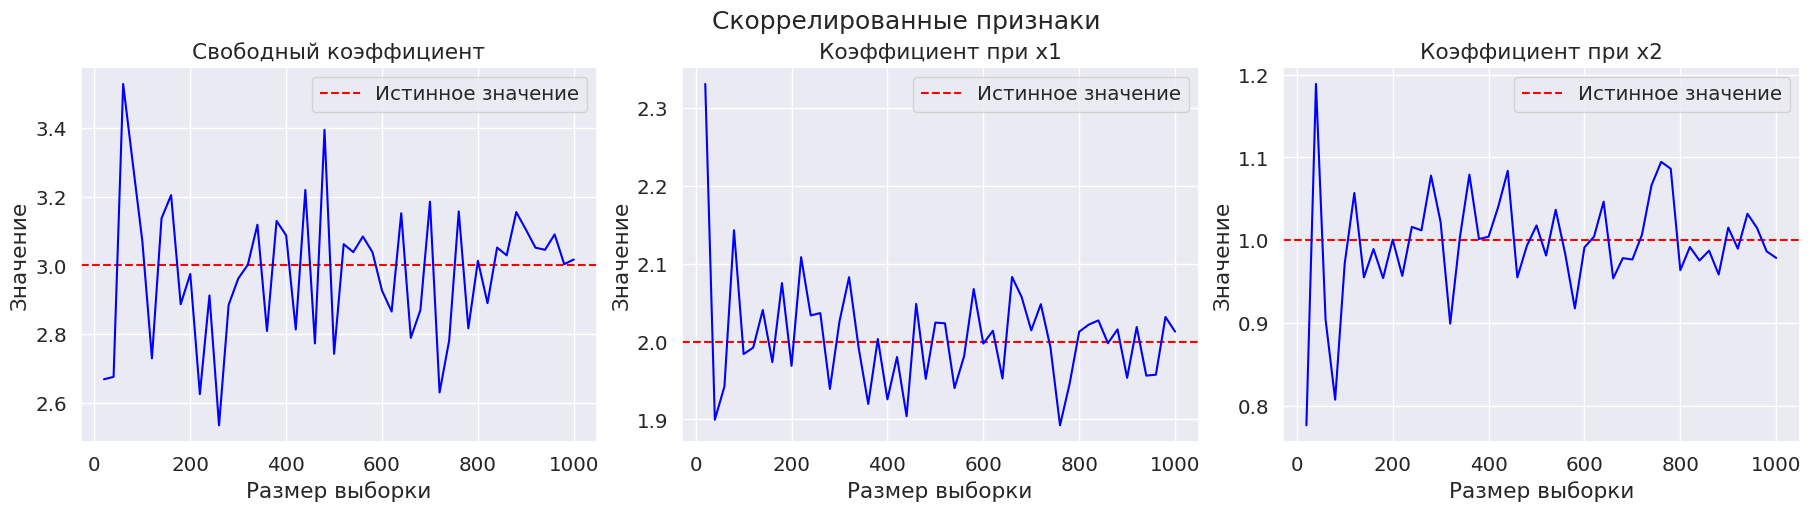

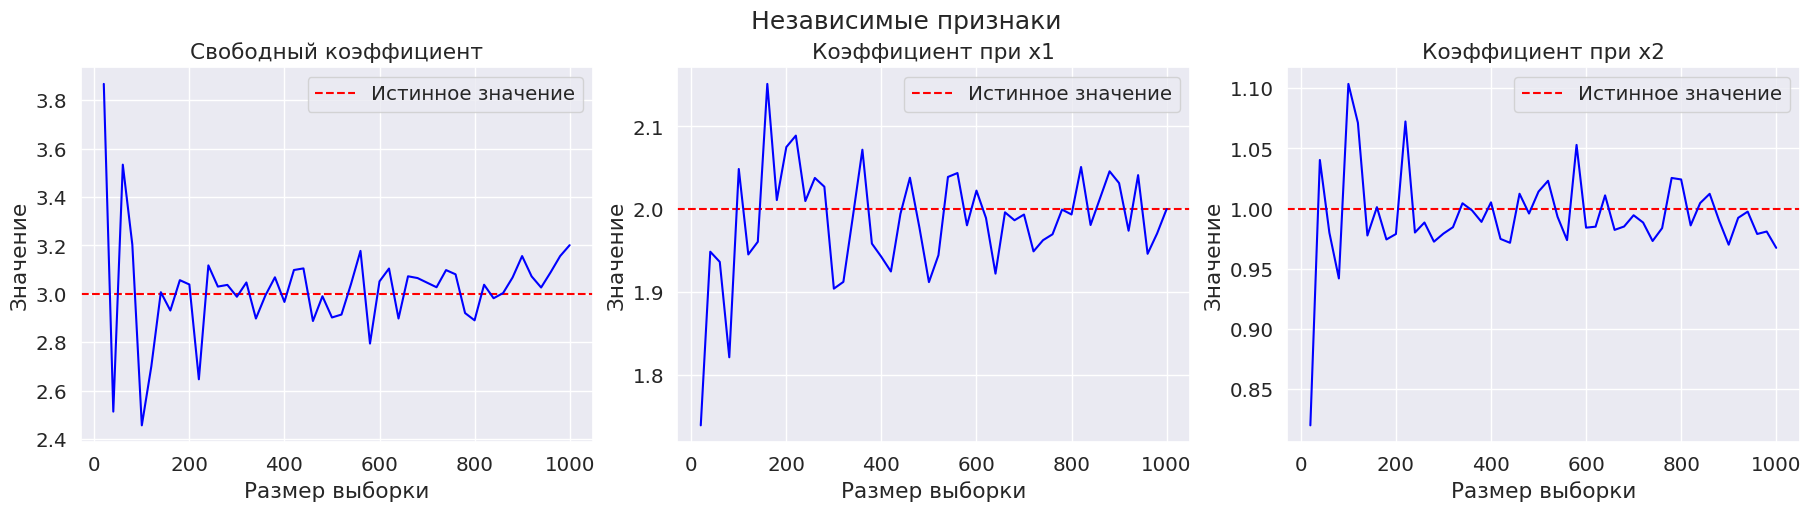

In [ ]:
plot_coefficient_convergence(generator_corr, true_intercept, true_coefs, "Скоррелированные признаки", n_runs=1, alpha=1)
plot_coefficient_convergence(generator_ind, true_intercept, true_coefs, "Независимые признаки", n_runs=1, alpha=1)


Повторим эксперимент много раз, чтобы увидеть закономерности, с которыми сходятся коэффициенты.

Повторные запуски позволяют учесть влияние случайности (например, шума в данных или начальных условий) и выявить устойчивые закономерности в оценках коэффициентов. Это даёт более надёжное представление о поведении модели и её чувствительности к входным данным.


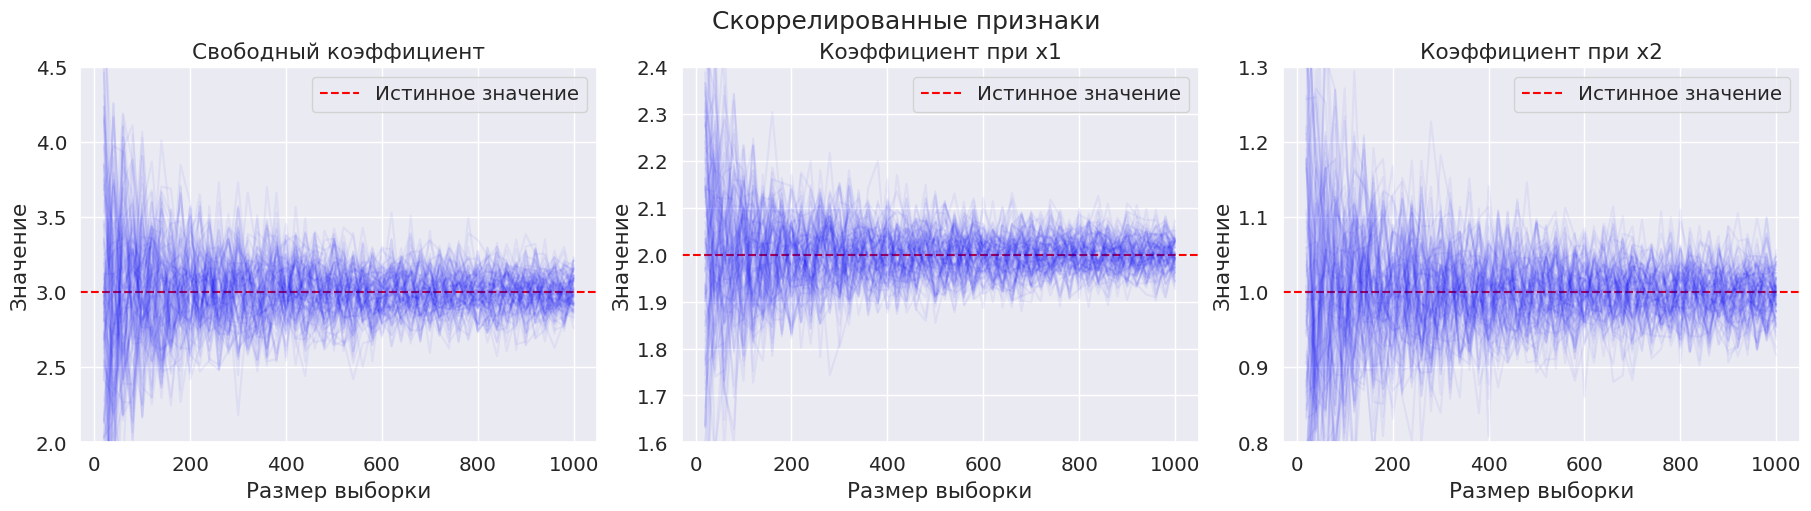

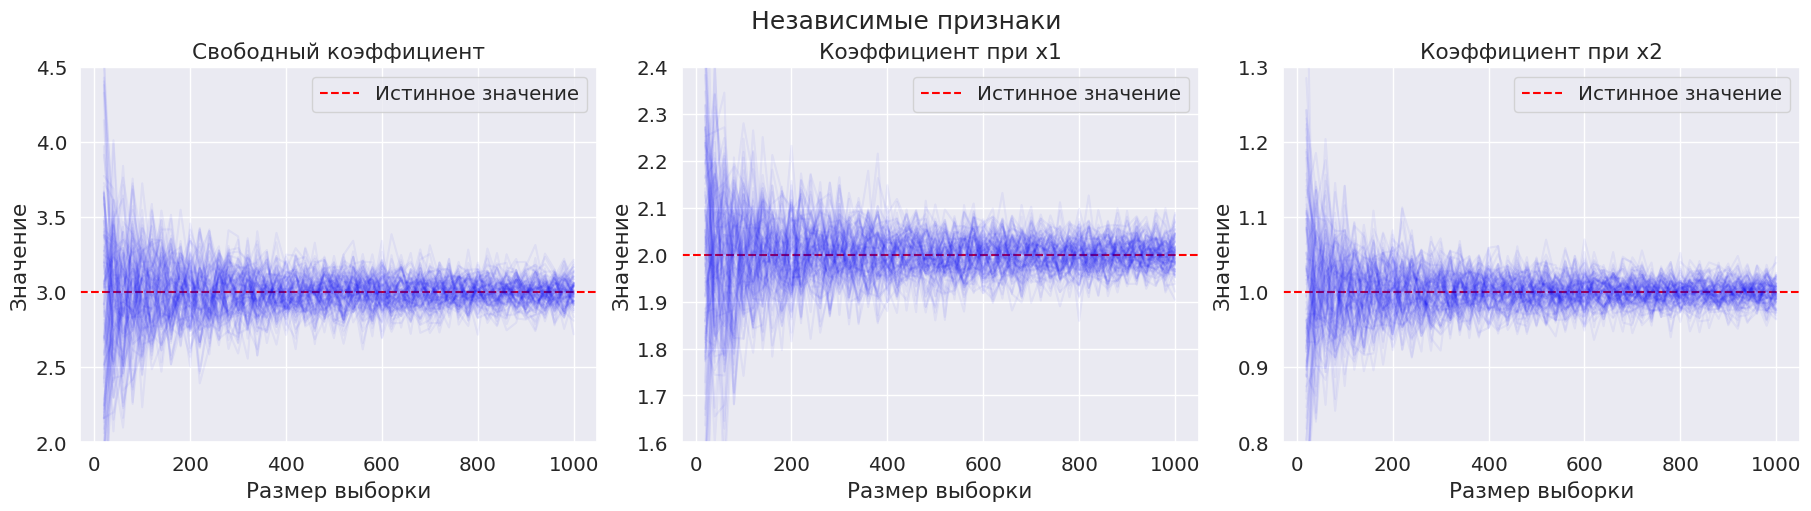

In [ ]:
ylims = [(2, 4.5), (1.6, 2.4), (0.8, 1.3)]  # Пределы осей Y

# Скоррелированные признаки
plot_coefficient_convergence(
    data_generator=generator_corr,
    true_intercept=true_intercept,
    true_coefs=true_coefs,
    title="Скоррелированные признаки",
    n_runs=100,
    alpha=0.05,
    ylims=ylims
)

# Независимые признаки
plot_coefficient_convergence(
    data_generator=generator_ind,
    true_intercept=true_intercept,
    true_coefs=true_coefs,
    title="Независимые признаки",
    n_runs=100,
    alpha=0.05,
    ylims=ylims
)

Видно, что в случае скоррелиронных признаков сходимость более медленная — распределение немного шире, дисперсия больше.

Теперь посмотрим на дисперсии предсказаний с множеством запусков.

In [ ]:
def calculate_variance(
    generator: Callable[..., Tuple[np.ndarray, np.ndarray]],
    sample_sizes: np.ndarray,
    n_runs: int = 20,
    **generator_kwargs
) -> np.ndarray:
    """
    Вычисляет дисперсию предсказаний линейной регрессии для разных размеров выборки.

    Параметры:
        generator: Функция-генератор данных. Принимает размер выборки и дополнительные аргументы.
                   Возвращает кортеж (X, y), где X — признаки, y — целевая переменная.
        sample_sizes: Массив размеров выборки (например, np.array([50, 100, 200, ...])).
        n_runs: Количество повторений эксперимента для усреднения результатов.
        **generator_kwargs: Дополнительные аргументы, передаваемые генератору данных.

    Возвращает:
        np.ndarray формы (n_runs, len(sample_sizes)) с дисперсиями предсказаний
        для каждой комбинации размера выборки и прогона.
    """
    all_runs = []

    for _ in range(n_runs):
        run_vars = []  # Дисперсии для одного прогона
        for size in sample_sizes:
            X, y = generator(size, **generator_kwargs)
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=42
            )
            model = LinearRegression().fit(X_train, y_train)
            y_pred = model.predict(X_test)
            run_vars.append(np.var(y_pred))  # Считаем дисперсию предсказаний
        all_runs.append(run_vars)

    return np.array(all_runs)

In [ ]:
def plot_with_shadows(
    all_variances: np.ndarray,
    sample_sizes: np.ndarray,
    label: str,
    color: str
) -> None:
    """
    Строит график дисперсии предсказаний с полупрозрачными кривыми отдельных прогонов
    и основной средней линией.

    Параметры:
        all_variances: Массив дисперсий формы (n_runs, n_sizes)
        sample_sizes: Массив размеров выборки
        label: Название линии для легенды
        color: Цвет линии
    """
    for run in all_variances:
        plt.plot(sample_sizes, run, color=color, alpha=0.05)
    mean_var = np.mean(all_variances, axis=0)
    plt.plot(sample_sizes, mean_var, color=color, label=label, linewidth=2.5)

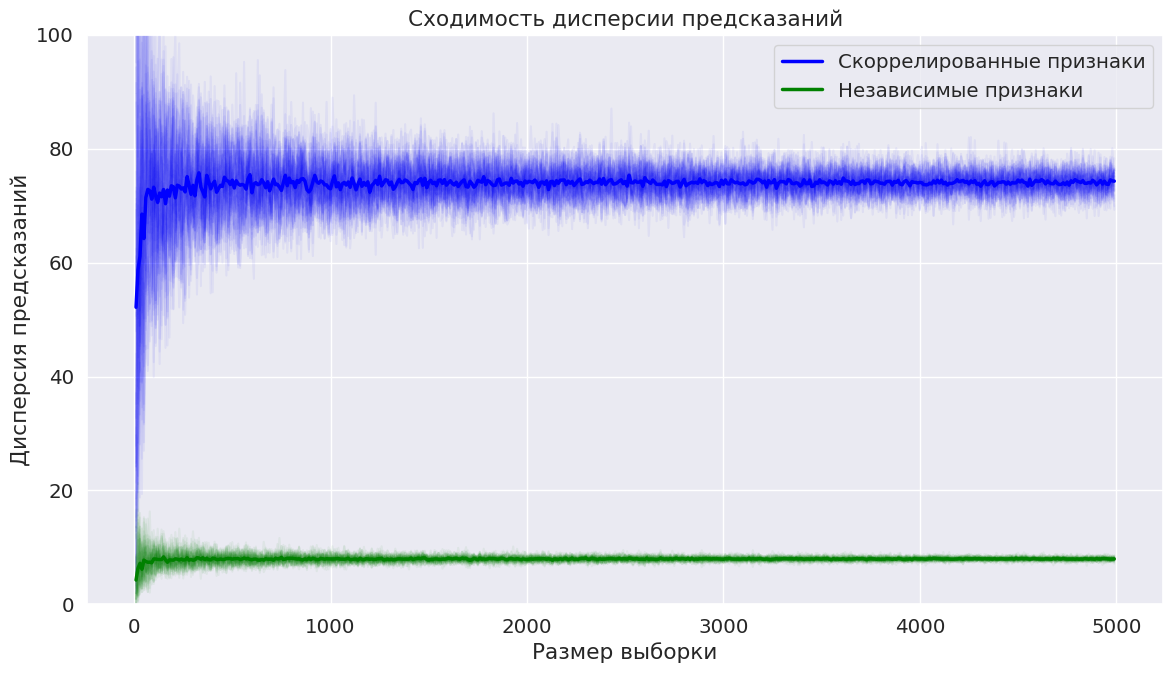

In [ ]:
# Параметры эксперимента
n_runs = 50
sample_sizes = np.arange(10, 5000, 10)

# Вычисление дисперсий
vars_corr = calculate_variance(generator_corr, sample_sizes, n_runs)
vars_indep = calculate_variance(generator_ind, sample_sizes, n_runs)

# Визуализация
plt.figure(figsize=(12, 7))

plot_with_shadows(vars_corr, sample_sizes, "Скоррелированные признаки", "blue")
plot_with_shadows(vars_indep, sample_sizes, "Независимые признаки", "green")

plt.xlabel("Размер выборки")
plt.ylabel("Дисперсия предсказаний")
plt.title("Сходимость дисперсии предсказаний")
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

Видно, что дисперсия предсказаний сильно меньше и быстрее сходится в случае независимых нескоррелированных признаков.

### 2. Сравнение ошибок линейной регрессии и нейронной сети на малых выборках

В реальном мире часто возникают ситуации, когда данных недостаточно для обучения больших моделей. Это может происходить, например, в медицинских задачах, где имеется малое число хорошо задокументированных случаев болезни или в системах алертинга редких, но важных событий. В таких случаях использование нейронной сети может быть неэффективным и лучше обратиться к более простым моделям.


Рассмотрим пример с явной линейной зависимостью, добавляя небольшую нелинейность и независимый гауссовский шум. На таких данных нейронная сеть априори должна показывать лучшие результаты по сравнению с линейной регрессией из-за своей большей гибкости. Однако на малых выборках это не всегда так.

Линейная регрессия ищет наилучшую линейную аппроксимацию данных. На нелинейных данных её ошибка будет высокой, но за счёт малого числа параметров она менее склонна к переобучению на малых выборках.

Нейронная сеть может аппроксимировать сложные нелинейные зависимости. Однако чем сложнее модель, тем больше данных ей нужно для обучения и тем больше возможность переобучения на шуме, если данных недостаточно.

In [ ]:
def generate_nonlinear_targets(
    X: np.ndarray,
    true_weights: np.ndarray,
    noise_std: float = 0.5
) -> np.ndarray:
    """
    Генерирует целевые значения с линейной и нелинейной зависимостью от признаков,
    а также добавляет гауссовский шум.

    Параметры:
        X: Массив признаков формы (n_samples, n_features).
        true_weights: Истинные веса линейной модели, форма (n_features,).
        noise_std: Стандартное отклонение гауссовского шума.

    Возвращает:
        np.ndarray
            Массив целевых значений формы (n_samples,), рассчитанных как:
            y = X @ true_weights + sin(X[:, 0]) + cos(X[:, 1]) * X[:, 2] + шум.
    """
    linear_part = X @ true_weights
    nonlinear_part = 1 * np.sin(X[:, 0]) + 1 * np.cos(X[:, 1]) * X[:, 2]
    noise = np.random.randn(X.shape[0]) * noise_std
    return linear_part + nonlinear_part + noise


In [ ]:
n_samples_total = 1000
n_features = 5 # количество признаков

X = np.random.randn(n_samples_total, n_features)
true_weights = np.array([1.5, -2.0, 0.7, 0.0, 3.3])
y = generate_nonlinear_targets(X, true_weights)

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Массивы для хранения ошибок
sizes = np.arange(5, len(X_train_full) + 1, 5)  # 5, 10, 15, ..., 80
linreg_mse = []
nn_mse = []

# Нейронка
class NN(nn.Module):
    def __init__(self, input_dim=2, hidden_size=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Гоним по размерам
for n_samples in sizes:
    X_train = X_train_full[:n_samples]
    y_train = y_train_full[:n_samples]

    # Линейная регрессия
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred_linreg = linreg.predict(X_test)
    linreg_mse.append(mean_squared_error(y_test, y_pred_linreg))

    # Нейронка
    model = NN(input_dim=n_features)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred_nn = model(X_test_tensor).numpy().flatten()
    nn_mse.append(mean_squared_error(y_test, y_pred_nn))

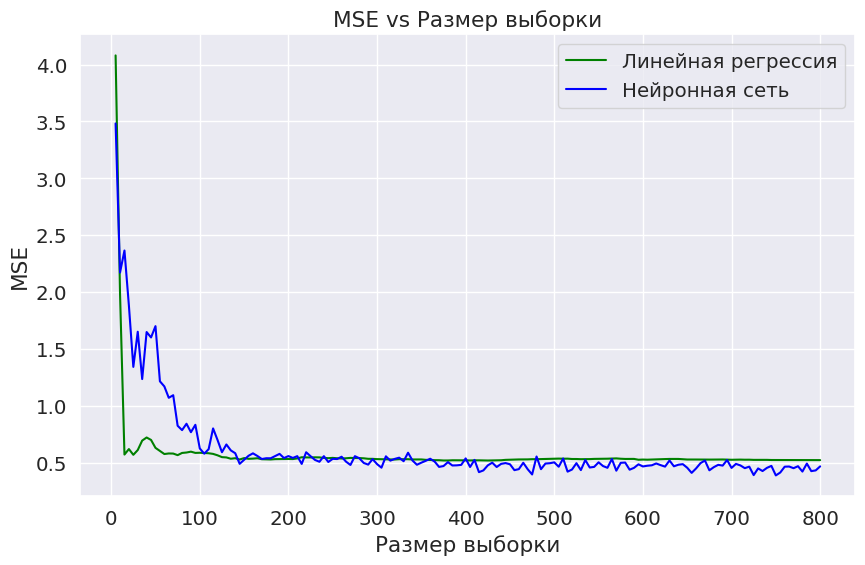

In [ ]:
# Рисуем
plt.figure(figsize=(10, 6))
plt.plot(sizes, linreg_mse, label='Линейная регрессия', color='green')
plt.plot(sizes, nn_mse, label='Нейронная сеть', color='blue')
plt.xlabel('Размер выборки')
plt.ylabel('MSE')
plt.title('MSE vs Размер выборки')
plt.legend()
plt.grid(True)
plt.show()


Давайте теперь сделаем множество запуксков.

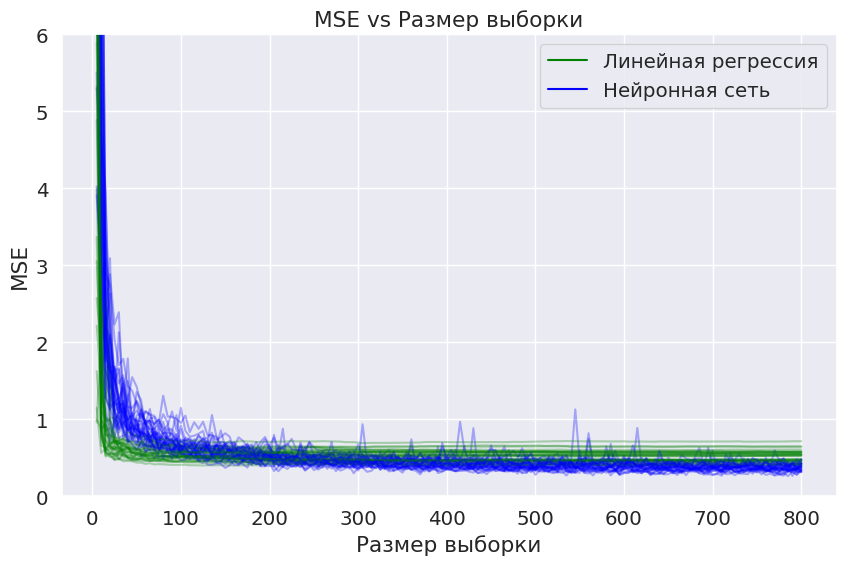

In [ ]:
n_runs = 30
plt.figure(figsize=(10, 6))

for run in range(n_runs):
    linreg_mse = []
    nn_mse = []

    # Генерим новые данные
    X = np.random.randn(n_samples_total, n_features)
    y = generate_nonlinear_targets(X, true_weights)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=run)

    for n_samples in sizes:
        X_train = X_train_full[:n_samples]
        y_train = y_train_full[:n_samples]

        # Линейная регрессия
        linreg = LinearRegression()
        linreg.fit(X_train, y_train)
        y_pred_linreg = linreg.predict(X_test)
        linreg_mse.append(mean_squared_error(y_test, y_pred_linreg))

        # Нейронка
        model = NN(input_dim=n_features)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

        model.train()
        for epoch in range(100):
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            y_pred_nn = model(X_test_tensor).numpy().flatten()
        nn_mse.append(mean_squared_error(y_test, y_pred_nn))

    # Рисуем одну траекторию для этого запуска
    plt.plot(sizes, linreg_mse, color='green', alpha=0.3)
    plt.plot(sizes, nn_mse, color='blue', alpha=0.3)

plt.xlabel('Размер выборки')
plt.ylabel('MSE')
plt.title('MSE vs Размер выборки')
plt.grid(True)

# Подписи для цвета
plt.plot([], [], color='green', label='Линейная регрессия')
plt.plot([], [], color='blue', label='Нейронная сеть')
plt.ylim(0, 6)
plt.legend()
plt.show()


На графике видно, что для выборок размера < 150 MSE линейной регрессии часто ниже, чем у нейронной сети. Это происходит потому, что:

1. Нейросеть имеет слишком много параметров для малого числа данных.

2. Линейная модель устойчивее к шуму благодаря своему простому виду.

3. При увеличении выборки нейросеть начинает выигрывать за счёт гибкости.

Для качественного обучения и инференса нейронной сети нужны большие данные, вычислительные мощности и время, что не всегда доступно в жизни. Поэтому не стоит гнаться за сложностью моделей, иногда можно остановиться и на простых бейзлайн решениях🤗

### 3. Зависимость качества модели от плотности трейновых точек

Как мы уже убедились, тренировочные данные оказывают огромное влияние на качество модели. Шум, скрытые зависимости и коррелированность признаков могут существенно ухудшить результаты. Но ещё важным фактором является плотность тренировочных данных — насколько хорошо они охватывают всю возможную выборку.


---
Представьте, что вы разрабатываете модель для прогнозирования температуры в разных городах по данным с метеорологических станций. Однако данные для обучения модели были собраны только из крупных городов, таких как Москва, Санкт-Петербург и несколько других крупных мегаполисов. Из-за этого данные о погодных условиях в менее населенных или удаленных районах (например, в сельской местности или в маленьких городах) слабо не представлены в тренировочных данных.

Если вы затем используете эту модель для прогнозирования температуры в любых городах, например, в маленьких городах или удаленных регионах, то она будет работать хуже. Это связано с тем, что модель "видела" только данные о больших городах с определенными климатическими характеристиками (например, более высокие температуры из-за эффекта урбанизации), но не учитывала особенности климата в менее густонаселенных районах (например, колебания температуры могут быть значительно больше).

В результате модель будет показывать низкую точность на этих менее представленных регионах, потому что она не научилась адекватно прогнозировать температуру для таких мест.

---

Чтобы продемонстрировать это на более простом уровне, представим себе геометрический пример с синтетическими данными. Возьмем двумерную нелинейную функцию и разместим точки тренировки таким образом, что они будут сосредоточены в нескольких областях с высокой плотностью, в то время как остальные области будут иметь равномерно распределенные точки или не иметь точек вообще.

Затем мы проверим качество модели на всей протяженности функции, используя сетку для оценки точности. Это покажет, как плотность тренировочных данных может влиять на способность модели правильно обобщать информацию на всю область возможных входных данных.

Следующая большая функцию генерирует наши сложные данные: сделаем несколько "ям" с разной плотностью точек.

In [ ]:
def true_function(x1: np.ndarray, x2: np.ndarray) -> np.ndarray:
    """
    Истинная функция, которую мы пытаемся аппроксимировать.
    Двумерная функция с пятью ямами (три большие и две маленькие).

    Параметры:
        x1: Массив значений для первой переменной (n_samples,).
        x2: Массив значений для второй переменной (n_samples,).

    Возвращает:
        np.ndarray
            Массив значений функции, рассчитанных для каждой точки.
    """
    # Первая яма (центр: (-2, 1), глубина: -3, радиус ~0.7)
    well1 = -3 * np.exp(-2 * ((x1 + 2)**2 + (x2 - 1)**2))

    # Вторая яма (центр: (0, 0), глубина: -3, радиус ~0.7)
    well2 = -3 * np.exp(-2 * ((x1 - 0)**2 + (x2 - 0)**2))

    # Третья яма (центр: (2, 2.5), глубина: -3, радиус ~0.7)
    well3 = -3 * np.exp(-2 * ((x1 - 2)**2 + (x2 - 2.5)**2))

    # Четвертая яма (маленькая, центр: (-1, -1), глубина: -1.5, радиус ~0.5)
    well4 = -1.5 * np.exp(-3 * ((x1 + 1)**2 + (x2 + 1)**2))

    # Пятая яма (маленькая, центр: (1.5, -0.5), глубина: -1.5, радиус ~0.5)
    well5 = -1.5 * np.exp(-3 * ((x1 - 1.5)**2 + (x2 + 0.5)**2))

    # Перемычки между ямами (плавные переходы)
    bridge1 = -1 * np.exp(-1.5 * ((x1 + 1)**2 + (x2 - 0.5)**2))  # Между первой и второй ямами
    bridge2 = -1 * np.exp(-1.5 * ((x1 - 1)**2 + (x2 - 1.25)**2))  # Между второй и третьей ямами
    bridge3 = -0.5 * np.exp(-2 * ((x1 + 0.5)**2 + (x2 + 0.5)**2))  # Между второй и четвертой ямами
    bridge4 = -0.5 * np.exp(-2 * ((x1 - 0.75)**2 + (x2 + 0.25)**2))  # Между второй и пятой ямами

    # Слабый нелинейный бэкграунд
    background = 0.1 * (np.sin(2 * x1) + np.cos(2 * x2)) + 0.05 * (x1**2 + x2**2)

    # Суммируем все компоненты
    return well1 + well2 + well3 + well4 + well5 + bridge1 + bridge2 + bridge3 + bridge4 + background


def generate_data(seed: int = 42) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Генерация обучающих и тестовых данных с новым распределением точек: 50-3-0.

    Параметры:
        seed: Число для задания начального состояния генератора случайных чисел.

    Возвращает:
        x_train: Массив обучающих данных (n_samples, 2).
        y_train: Массив целевых значений для обучающих данных (n_samples,).
        x_test: Массив тестовых данных (n_samples, 2).
        y_test: Массив целевых значений для тестовых данных (n_samples,).
    """
    np.random.seed(seed)

    # Центры четырех ям
    circle_centers = [(-2, 1), (-1.5, 2), (0.5, -2), (0, 0), (2, 2.5)]
    dense_points = []

    # Первая яма: 50 точек
    num_points_first_circle = 50
    for _ in range(num_points_first_circle):
        theta = np.random.uniform(0, 2 * np.pi)
        r = np.random.uniform(0, 0.7)
        x = circle_centers[0][0] + r * np.cos(theta)
        y = circle_centers[0][1] + r * np.sin(theta)
        dense_points.append([x, y])

    # Первая яма, продолжение: 50 точек
    num_points_first_circle = 50
    for _ in range(num_points_first_circle):
        theta = np.random.uniform(0, 2 * np.pi)
        r = np.random.uniform(0, 0.7)
        x = circle_centers[1][0] + r * np.cos(theta)
        y = circle_centers[1][1] + r * np.sin(theta)
        dense_points.append([x, y])

    # Точки вне ямы
    num_points_first_circle = 15
    for _ in range(num_points_first_circle):
        theta = np.random.uniform(0, 2 * np.pi)
        r = np.random.uniform(0, 0.7)
        x = circle_centers[2][0] + r * np.cos(theta)
        y = circle_centers[2][1] + r * np.sin(theta)
        dense_points.append([x, y])

    # Третья яма: 3 точки
    num_points_second_circle = 3
    for _ in range(num_points_second_circle):
        theta = np.random.uniform(0, 2 * np.pi)
        r = np.random.uniform(0, 0.7)
        x = circle_centers[2][0] + r * np.cos(theta)
        y = circle_centers[3][1] + r * np.sin(theta)
        dense_points.append([x, y])

    # Третья яма: 0 точек — пропускаем

    dense_points = np.array(dense_points)

    # Добавляем немного рандомных точек по области
    random_points = []
    while len(random_points) < 15:
        point = np.random.uniform(-3, 3, 2)
        # Проверяем, что точка не попадает в третью яму
        distance_to_third_well = np.linalg.norm(point - np.array([2, 2.5]))
        if distance_to_third_well > 0.7:
            random_points.append(point)

    random_points = np.array(random_points)

    # Объединяем всё это
    x_train = np.vstack([dense_points, random_points])

    # Генерация тестовой сетки
    x_test = np.linspace(-3, 3, 20)
    y_test = np.linspace(-3, 3, 20)
    x_test_points = np.array([[x, y] for x in x_test for y in y_test])

    # Значения целевой функции
    y_train = true_function(x_train[:, 0], x_train[:, 1]) + np.random.normal(0, 0.1, len(x_train))
    y_test = true_function(x_test_points[:, 0], x_test_points[:, 1])

    return x_train, y_train, x_test_points, y_test

Обучим линейную и регрессию и нейронную сеть с несколькими слоями. Такие могут приближать сложные нелинейные зависимости, поэтому в местах, где тренировочных данных будет достаточно, она обучится хорошо.

In [ ]:
# Генерация данных
x_train, y_train, x_test, y_test = generate_data()

# Обучение линейной регрессии
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
y_pred_lin = lin_reg.predict(x_test)


# Конвертация данных в тензоры PyTorch
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# Инициализация модели, функции потерь и оптимизатора
nn_model = NN() # Используем ту же нейронку, что в прошлой задаче
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.01)

# Обучение модели
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = nn_model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Предсказания на тестовых данных
with torch.no_grad():
    y_pred_nn = nn_model(x_test_tensor).numpy().flatten()

In [ ]:
# Создаем сетку для heatmap
x_grid = np.linspace(-3, 3, 100)
y_grid = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_points = np.column_stack([xx.ravel(), yy.ravel()])

# Получаем предсказания на сетке
with torch.no_grad():
    grid_pred_nn = nn_model(torch.tensor(grid_points, dtype=torch.float32)).numpy().reshape(xx.shape)
grid_pred_lin = lin_reg.predict(grid_points).reshape(xx.shape)
true_values = true_function(xx, yy)

# Вычисляем ошибки
error_lin = np.abs(true_values - grid_pred_lin)
error_nn = np.abs(true_values - grid_pred_nn)
mean_error_lin = np.mean(error_lin)
mean_error_nn = np.mean(error_nn)

Большой код для визуализации.

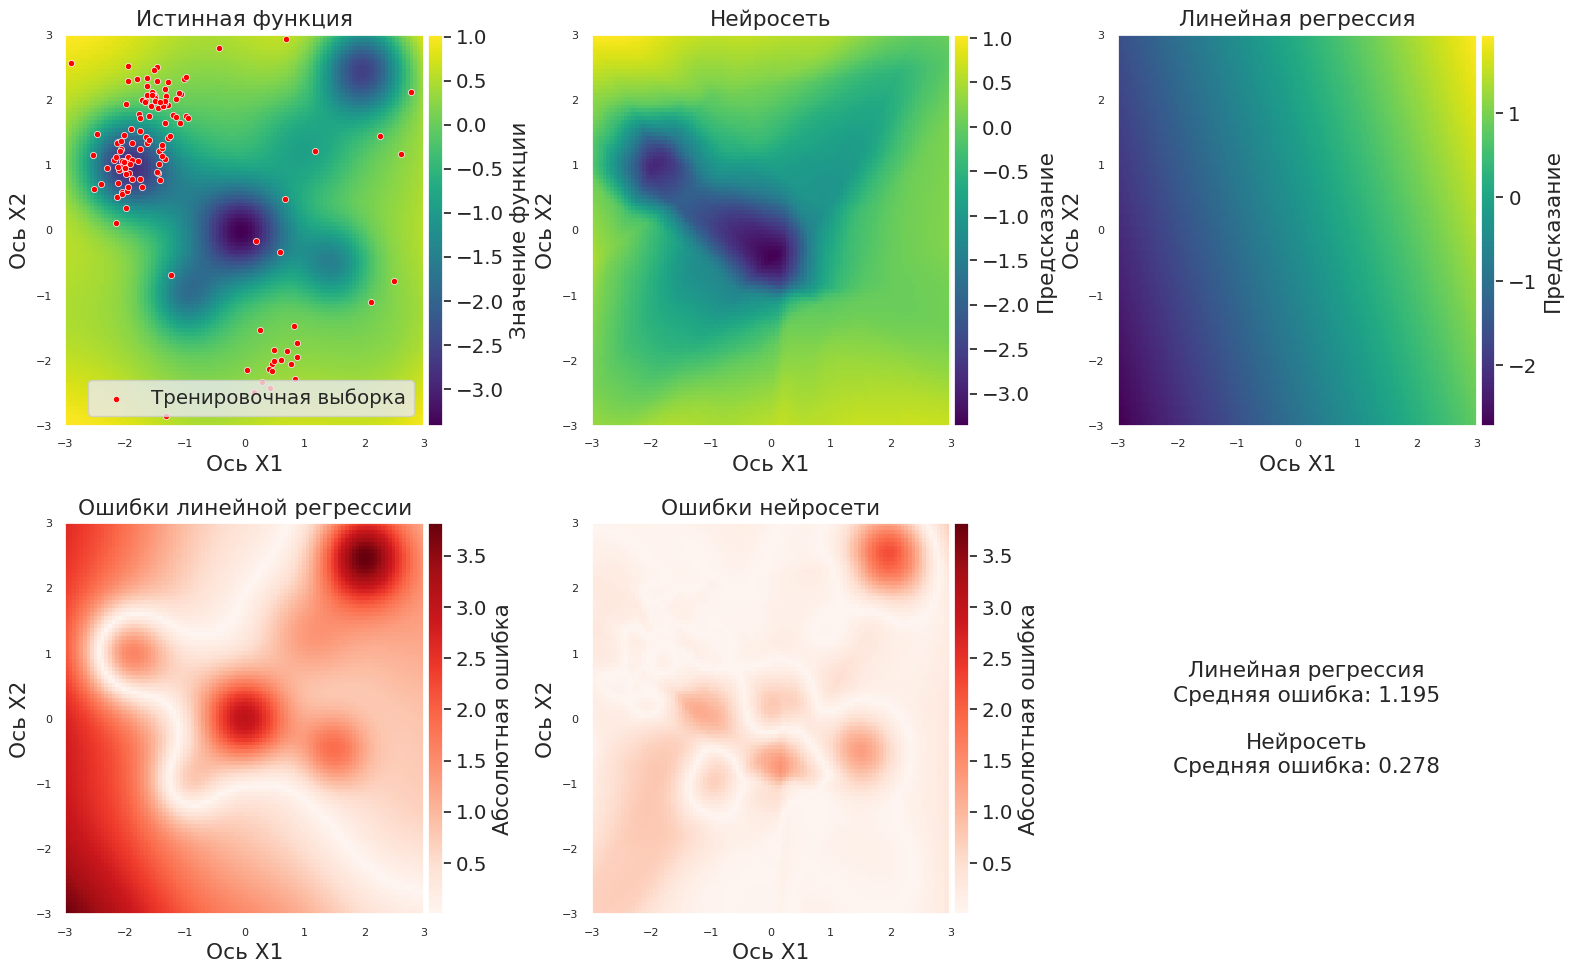

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
titles = ['Истинная функция', 'Нейросеть', 'Линейная регрессия',
          'Ошибки линейной регрессии', 'Ошибки нейросети', 'Сводка ошибок']


# Общие параметры для графиков
plot_params = {
    'extent': [-3, 3, -3, 3],
    'origin': 'lower',
    'aspect': 'auto'
}

def create_subplot(ax, data, title, cmap, cbar_label, add_scatter=True, vmax=None):
    im = ax.imshow(data, **plot_params, cmap=cmap, vmax=vmax)

    if add_scatter:
        scatter = ax.scatter(
            x_train[:, 0], x_train[:, 1],
            color='red', edgecolor='white', linewidth=0.5, s=20,
            label='Тренировочная выборка'
        )
        ax.legend(loc='lower right', frameon=True)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.04)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(cbar_label)

    ax.set_title(title)
    ax.set_xlabel('Ось X1')
    ax.set_ylabel('Ось X2')
    ax.tick_params(labelsize=8)
    ax.grid(False)

# Сводка
axes[1, 2].axis('off')
summary_text = (
    f'Линейная регрессия\nСредняя ошибка: {mean_error_lin:.3f}\n\n'
    f'Нейросеть\nСредняя ошибка: {mean_error_nn:.3f}'
)
axes[1, 2].text(0.5, 0.5, summary_text, ha='center', va='center')

# Построение остальных
create_subplot(axes[0, 0], true_values, titles[0], 'viridis', 'Значение функции')
create_subplot(axes[0, 1], grid_pred_nn, titles[1], 'viridis', 'Предсказание', add_scatter=False)
create_subplot(axes[0, 2], grid_pred_lin, titles[2], 'viridis', 'Предсказание', add_scatter=False)
create_subplot(axes[1, 0], error_lin, titles[3], 'Reds', 'Абсолютная ошибка', add_scatter=False, vmax=np.max(error_lin))
create_subplot(axes[1, 1], error_nn, titles[4], 'Reds', 'Абсолютная ошибка', add_scatter=False, vmax=np.max(error_lin))

# Чуть больше места между графиками
plt.subplots_adjust(left=0.06, right=0.94, top=0.93, bottom=0.08, hspace=0.4, wspace=0.5)
plt.tight_layout()
plt.show()


Сравнивая графики предсказания нейронной сети с истинной функцией мы видим, что ошибка возрастает в зависимости от плотности тренировочных данных: в яме (-2, 1) с высокой плотностью — нейронная сеть имеет наименьшую ошибку, в яме (0, 0), где у нас оказалось всего три точки — она неточно предсказала расположение и размер ямы, а ямы, где тренировочных точек нет вообще — она естественно не угадала.

Это наблюдение должно показать, насколько важно иметь репрезентативную выборку для обучения:)